<a href="https://colab.research.google.com/github/BilalAsifB/Machine_Learning_Projects/blob/main/alzheimer's_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's Disease Classification

> Imports

In [ ]:
!pip install boruta --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
import warnings
import zipfile
import os

In [ ]:
%matplotlib inline
plt.style.use('dark_background')
warnings.filterwarnings('ignore')

> Downloading data from Kaggle

In [ ]:
def setup_kaggle():
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir -p ~/.kaggle
    !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API is set up!")

In [ ]:
setup_kaggle()

Mounted at /content/drive
Kaggle API is set up!


In [ ]:
!kaggle datasets download rabieelkharoua/alzheimers-disease-dataset --quiet

Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
with zipfile.ZipFile('alzheimers-disease-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
print(os.listdir('data'))

['alzheimers_disease_data.csv']


In [ ]:
df = pd.read_csv('data/alzheimers_disease_data.csv')

In [ ]:
df.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

In [ ]:
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PatientID,2149.0,5825.000000,620.507185,4751.000000,5288.000000,5825.000000,6362.000000,6899.000000
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346


In [ ]:
df.drop(columns=['PatientID', 'DoctorInCharge'], inplace=True)

In [ ]:
categorical_features = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
    'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression',
    'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion',
    'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]

In [ ]:
continuous_features = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP','CholesterolTotal', 'CholesterolLDL',
    'CholesterolHDL','CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment','ADL'
]

In [ ]:
class CategoricalPlotter:
    def __init__(self, data, target_column):
        """
        Initialize the CategoricalPlotter with the dataset and target column.

        Parameters:
        - data: pandas DataFrame containing both features and the target column.
        - target_column: string, name of the column to be used as the target variable.
        """
        self.data = data
        self.target_column = target_column
        self.fig, self.axes = plt.subplots(
            nrows=6, ncols=3, figsize=(18, 24)
        )
        self.axes = self.axes.flatten()

    def plot_categorical(self, idx, feature):
        """
        Plot a countplot for a given categorical feature against the target column.

        Parameters:
        - idx: index of the subplot in the grid.
        - feature: string, name of the categorical feature to plot.
        """
        ax = self.axes[idx]
        sns.countplot(
            data=self.data, x=feature, hue=self.target_column, ax=ax, palette='bright', edgecolor='white', linewidth=2
        )
        ax.set_title(
            f'{feature.capitalize()} vs {self.target_column.capitalize()}', fontsize=12, fontweight='bold'
        )
        ax.set_ylabel('Count', fontsize=10)
        ax.set_xlabel(feature.capitalize(), fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    def show_categorical_plots(self, categorical_features):
        """
        Generate and display the plots for all categorical features.

        Parameters:
        - categorical_features: list of strings, names of the categorical features to plot.
        """
        for idx, feature in enumerate(categorical_features):
            if idx < len(self.axes):
                self.plot_categorical(idx, feature)
        for idx in range(len(categorical_features), len(self.axes)):
            self.fig.delaxes(self.axes[idx])
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

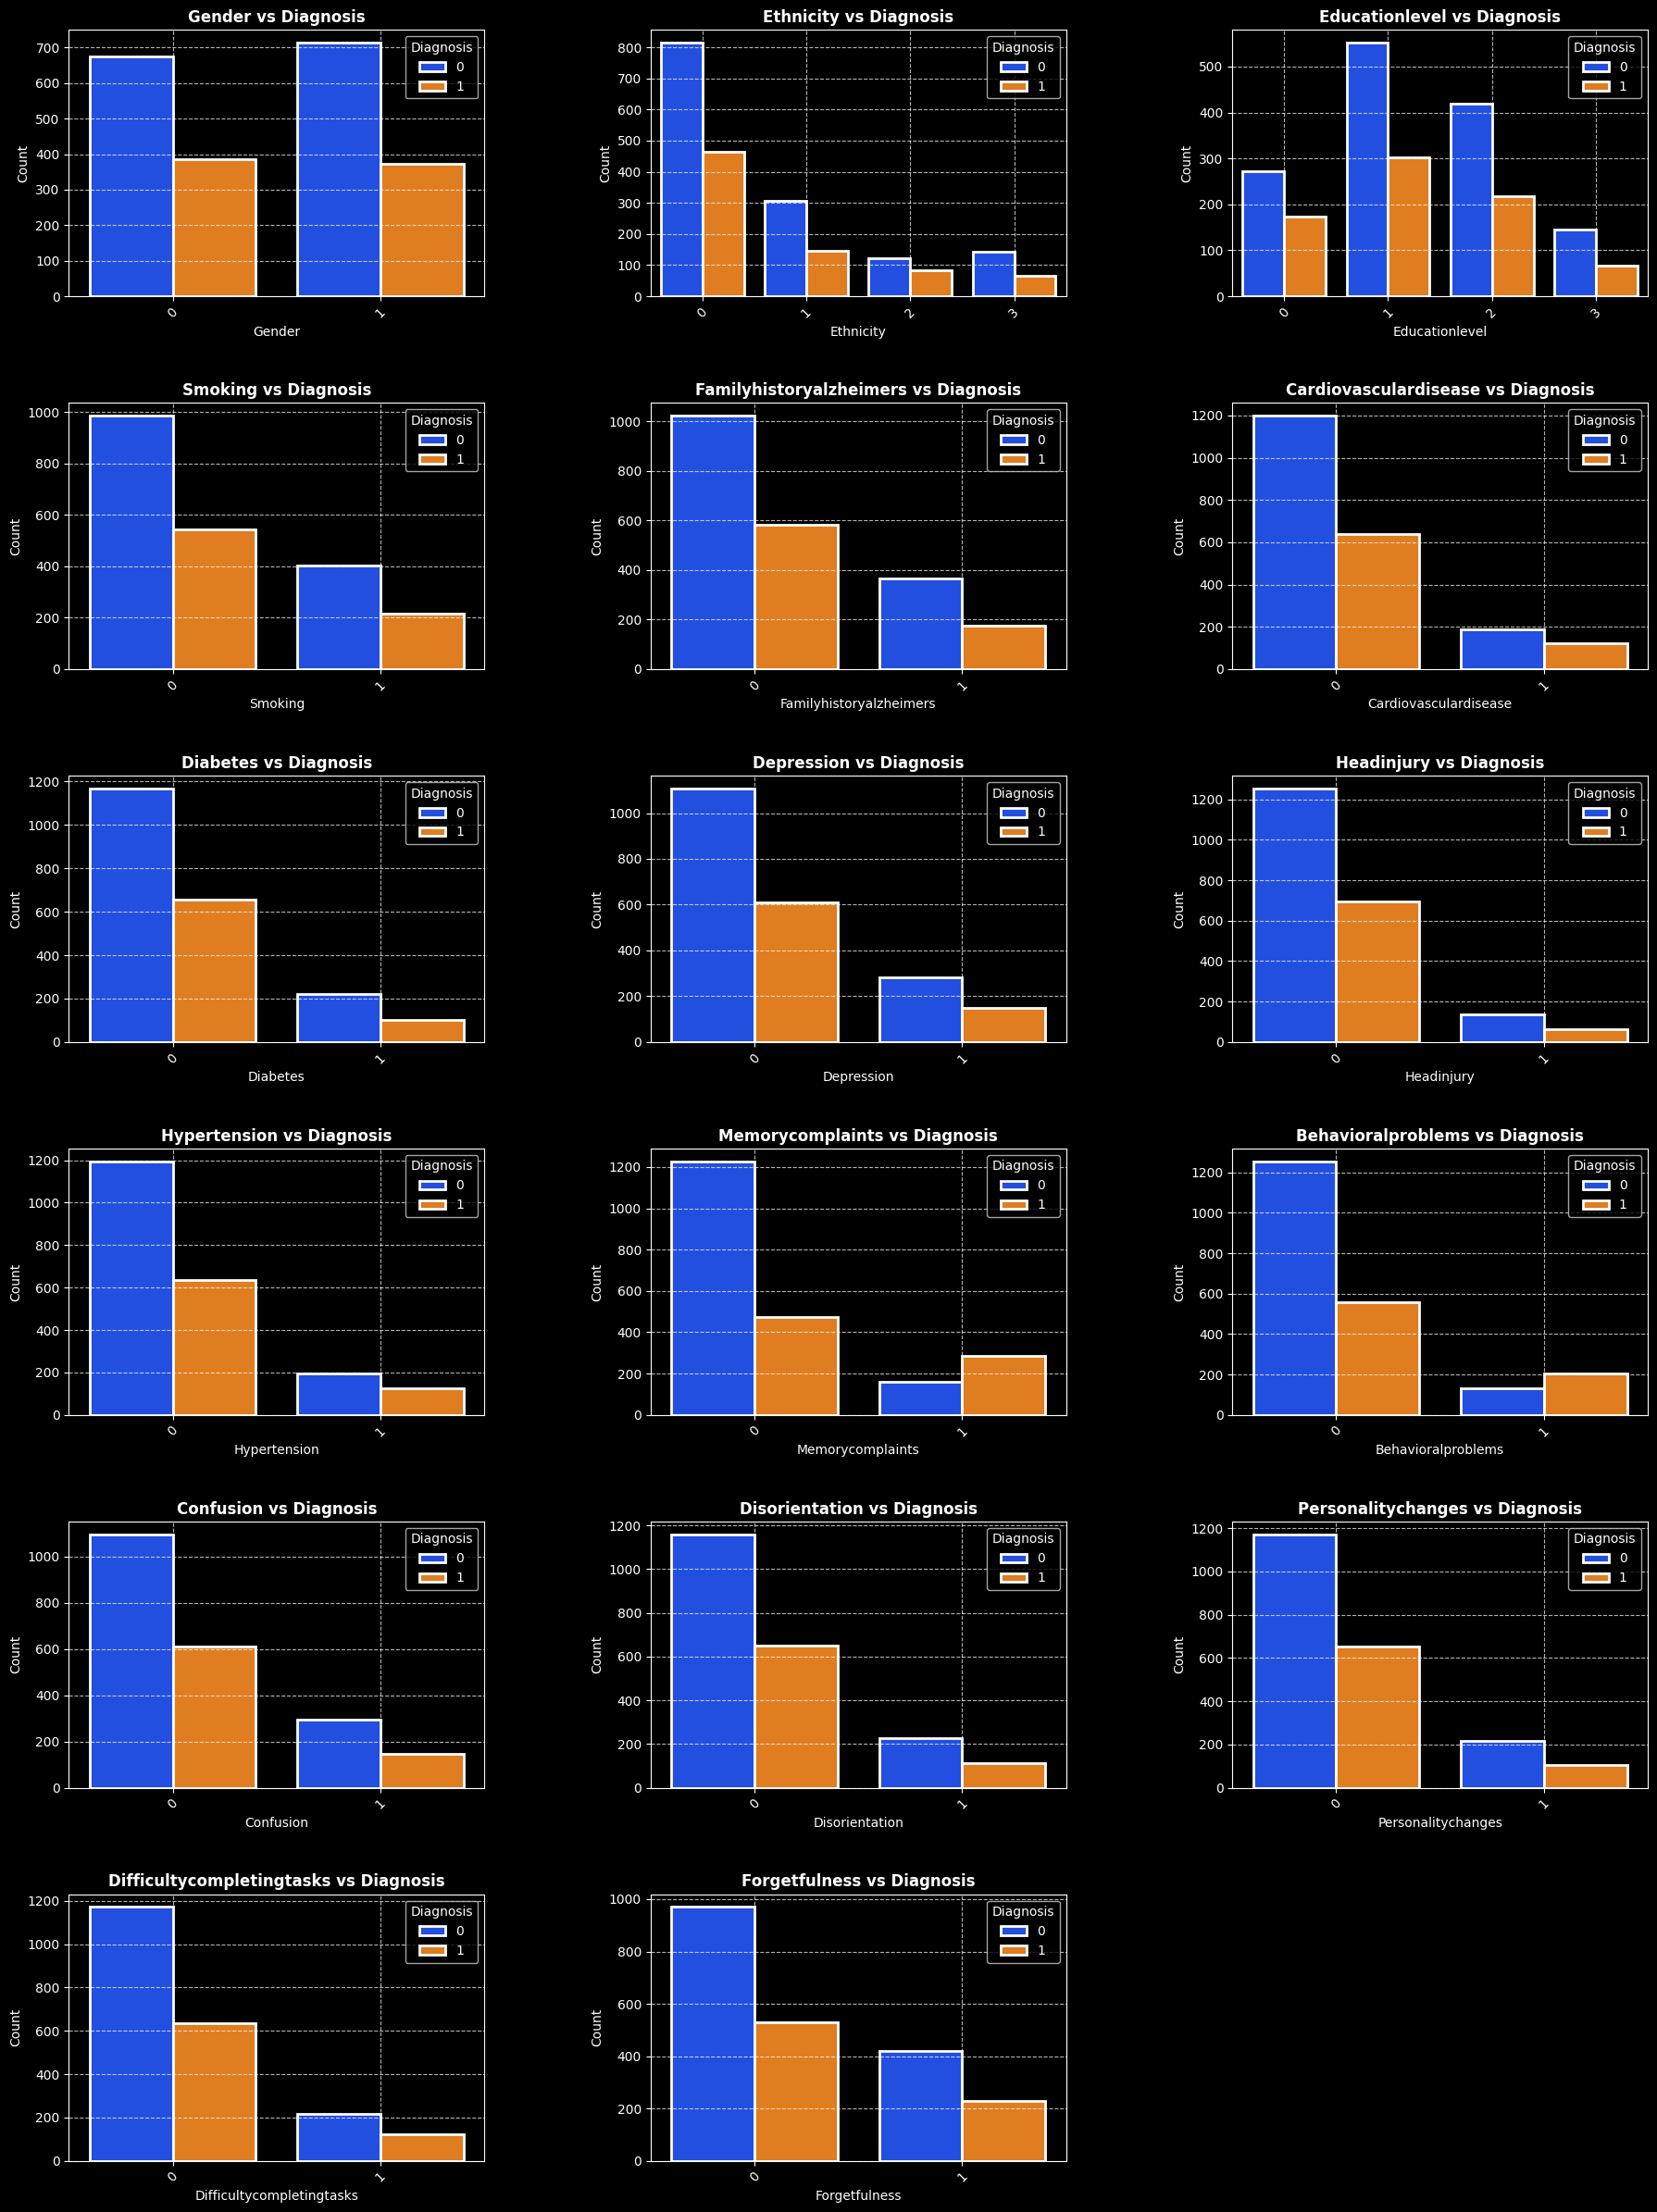

In [ ]:
plotter = CategoricalPlotter(df, target_column='Diagnosis')
plotter.show_categorical_plots(categorical_features)

In [ ]:
class ContinuousPlotter:
    def __init__(self, data):
        """
        Initialize the ContinuousPlotter with the dataset.

        Parameters:
        - data: pandas DataFrame containing continuous features.
        """
        self.data = data
        self.fig, self.axes = plt.subplots(
            nrows=5, ncols=3, figsize=(18, 24)
        )
        self.axes = self.axes.flatten()

    def plot_distribution(self, idx, feature):
        """
        Plot the distribution for a given continuous feature.

        Parameters:
        - idx: index of the subplot in the grid.
        - feature: string, name of the continuous feature to plot.
        """
        ax = self.axes[idx]
        sns.histplot(
            self.data[feature], ax=ax, color='blue', bins=30, stat='density'
        )
        sns.kdeplot(
            self.data[feature], ax=ax, linestyle='-', color='red', linewidth=2
        )
        ax.set_title(
            f'Distribution of {feature.capitalize()}', fontsize=12, fontweight='bold'
        )
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_xlabel(feature.capitalize(), fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
    def show_distributions(self, continuous_features):
        """
        Generate and display the distribution plots for all continuous features.

        Parameters:
        - continuous_features: list of strings, names of the continuous features to plot.
        """
        for idx, feature in enumerate(continuous_features):
            if idx < len(self.axes):
                self.plot_distribution(idx, feature)
        for idx in range(len(continuous_features), len(self.axes)):
            self.fig.delaxes(self.axes[idx])
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

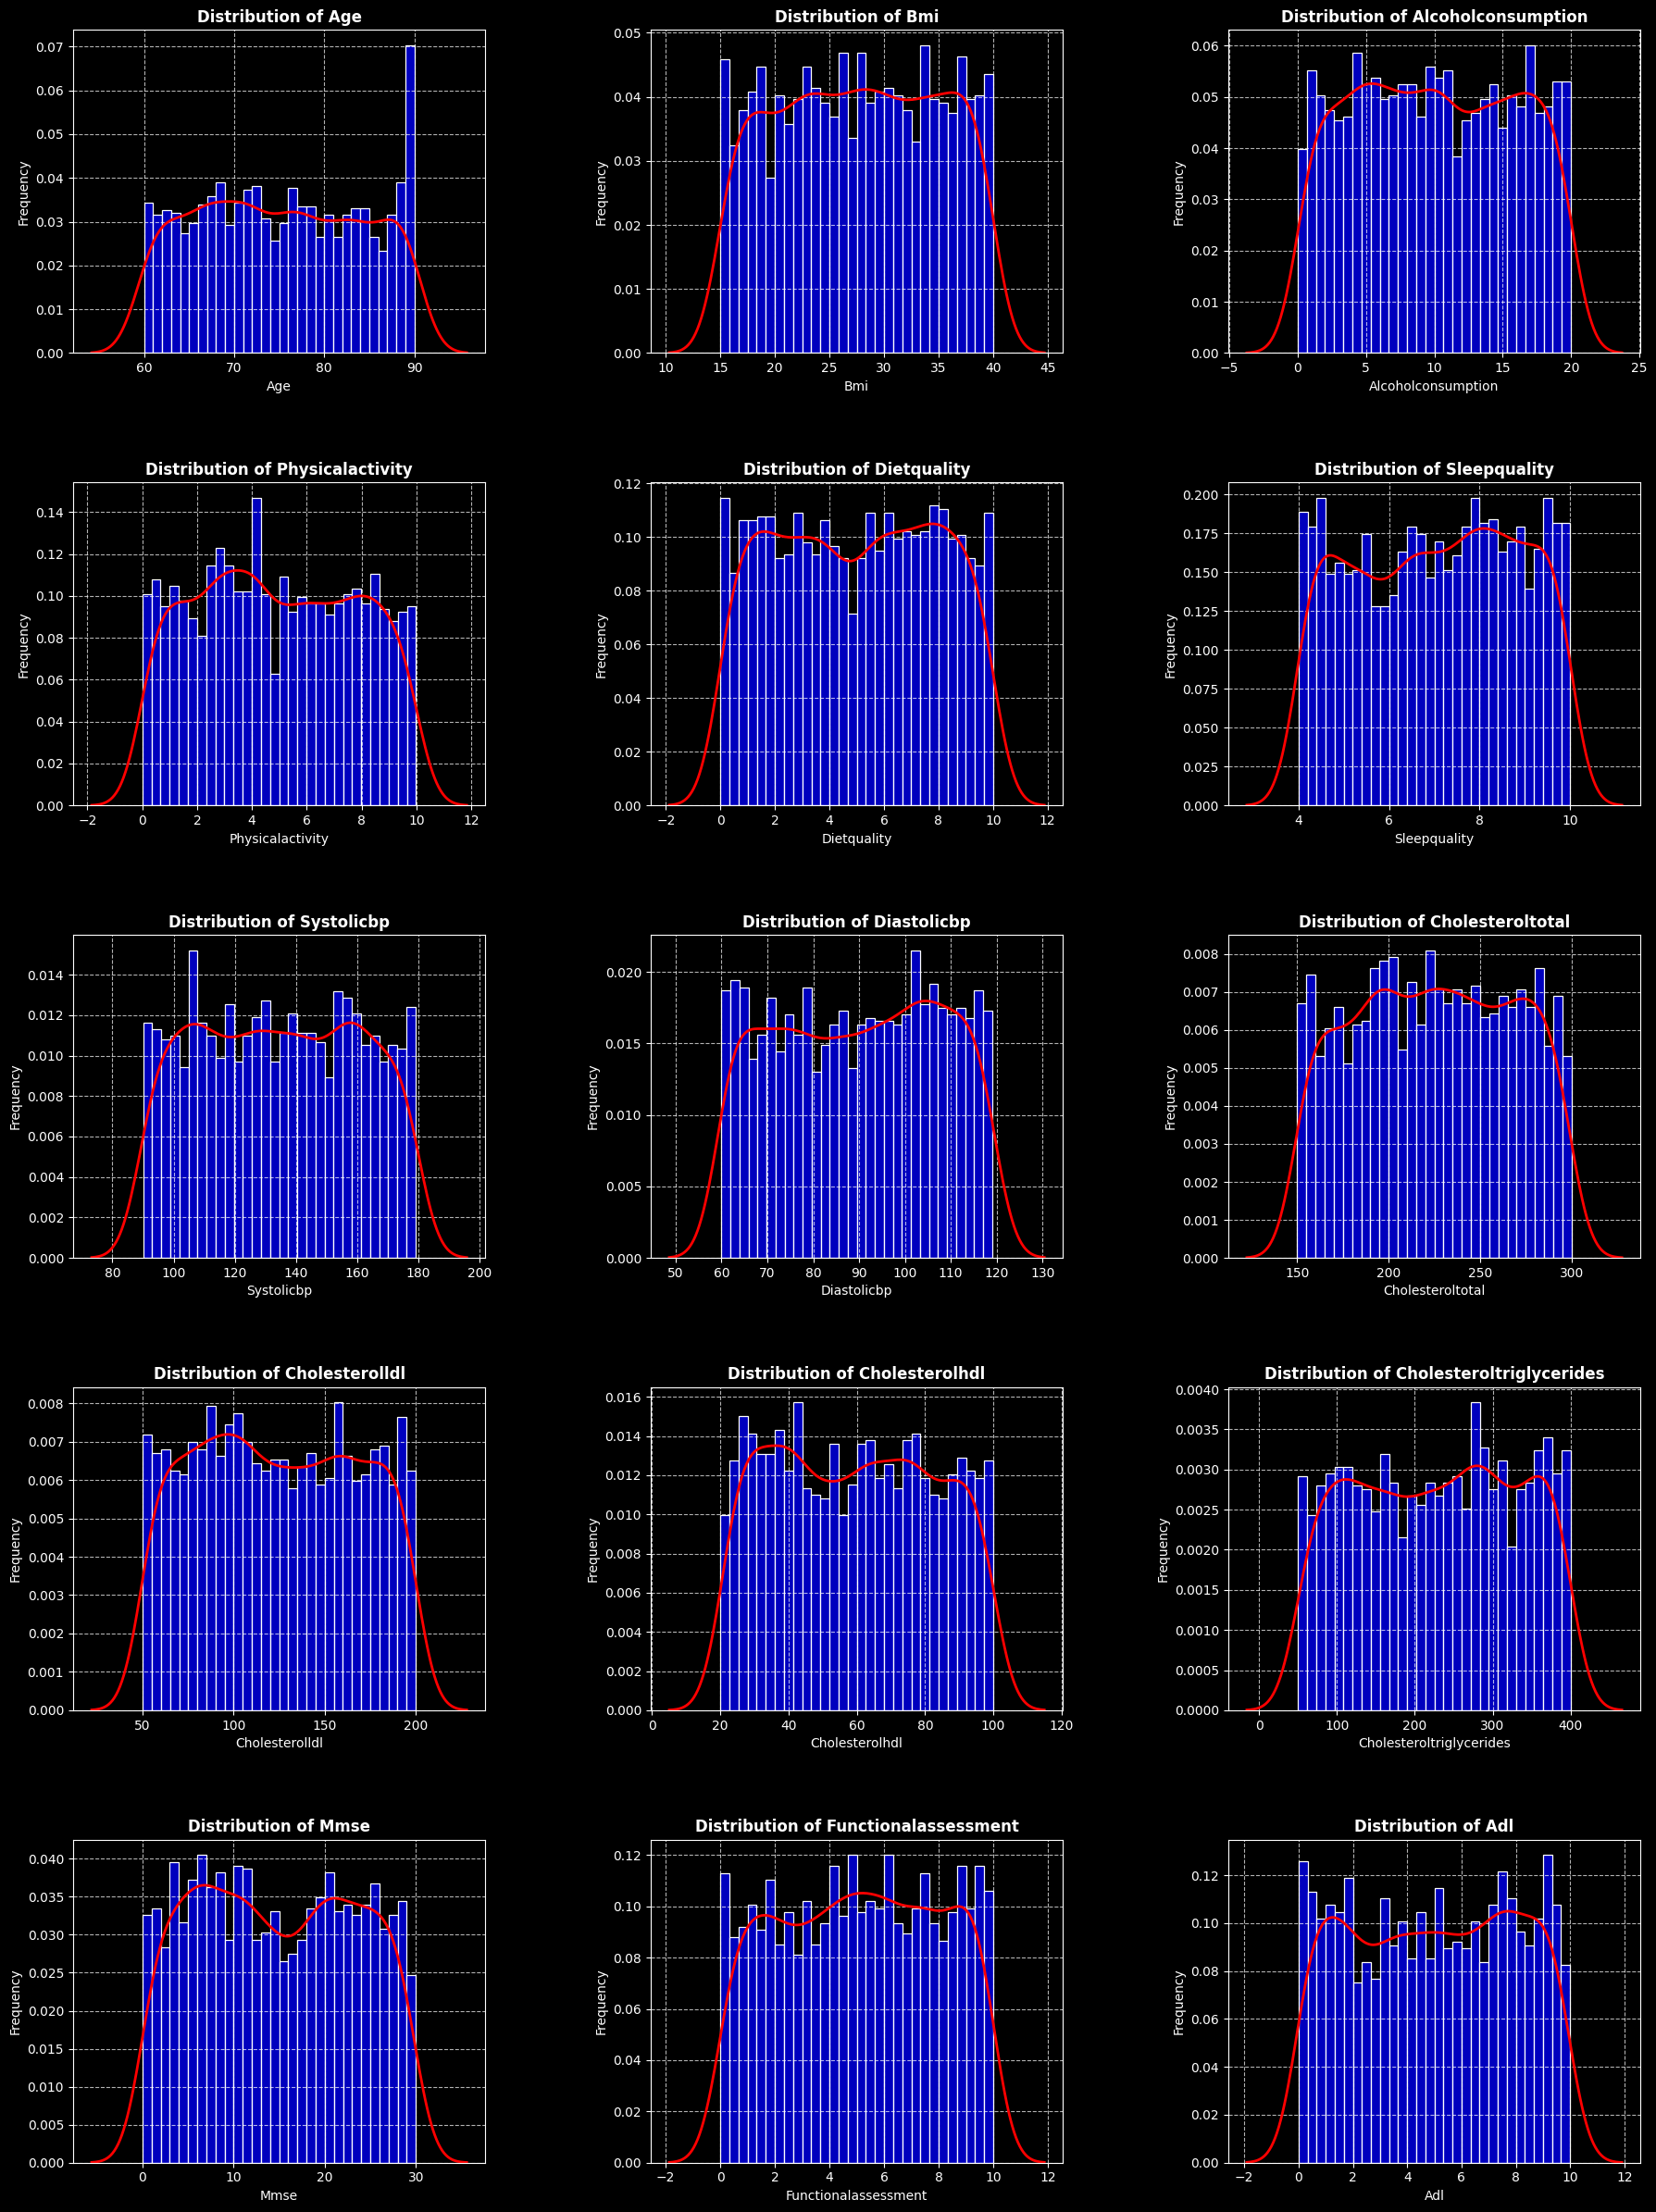

In [ ]:
plotter = ContinuousPlotter(df)
plotter.show_distributions(continuous_features)

#### Splitting the Data into Train and Test Data

In [ ]:
X = df.drop(columns=['Diagnosis'])
Y = df['Diagnosis']

> Splitting into Train and Validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, stratify=Y, shuffle=True, random_state=42
)

#### Handling Outlier values

In [ ]:
class BoxPlotter:
    def __init__(self, X, Y):
        self.X_train = X
        self.y_train = Y.astype('category')
        self.fig, self.axes = plt.subplots(
            nrows=5, ncols=3, figsize=(18, 20)
        )

    def plot_box(self, row, col, x):
        ax = self.axes[row, col]
        sns.boxplot(
            data=self.X_train, x=x, y=self.y_train, ax=ax, palette='bright', linecolor='white', linewidth=2
        )
        ax.set_title(
            f'{x.capitalize()} vs Diagnosis', fontsize=12, fontweight='bold'
        )
        ax.set_ylabel('Diagnosis', fontsize=10)
        ax.set_xlabel(x.capitalize(), fontsize=10)
        ax.grid(
            True, linestyle='--', alpha=0.7
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    def show_box_plots(self):
        for idx in range(len(continuous_features), 15):
            self.fig.delaxes(self.axes.flatten()[idx])
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

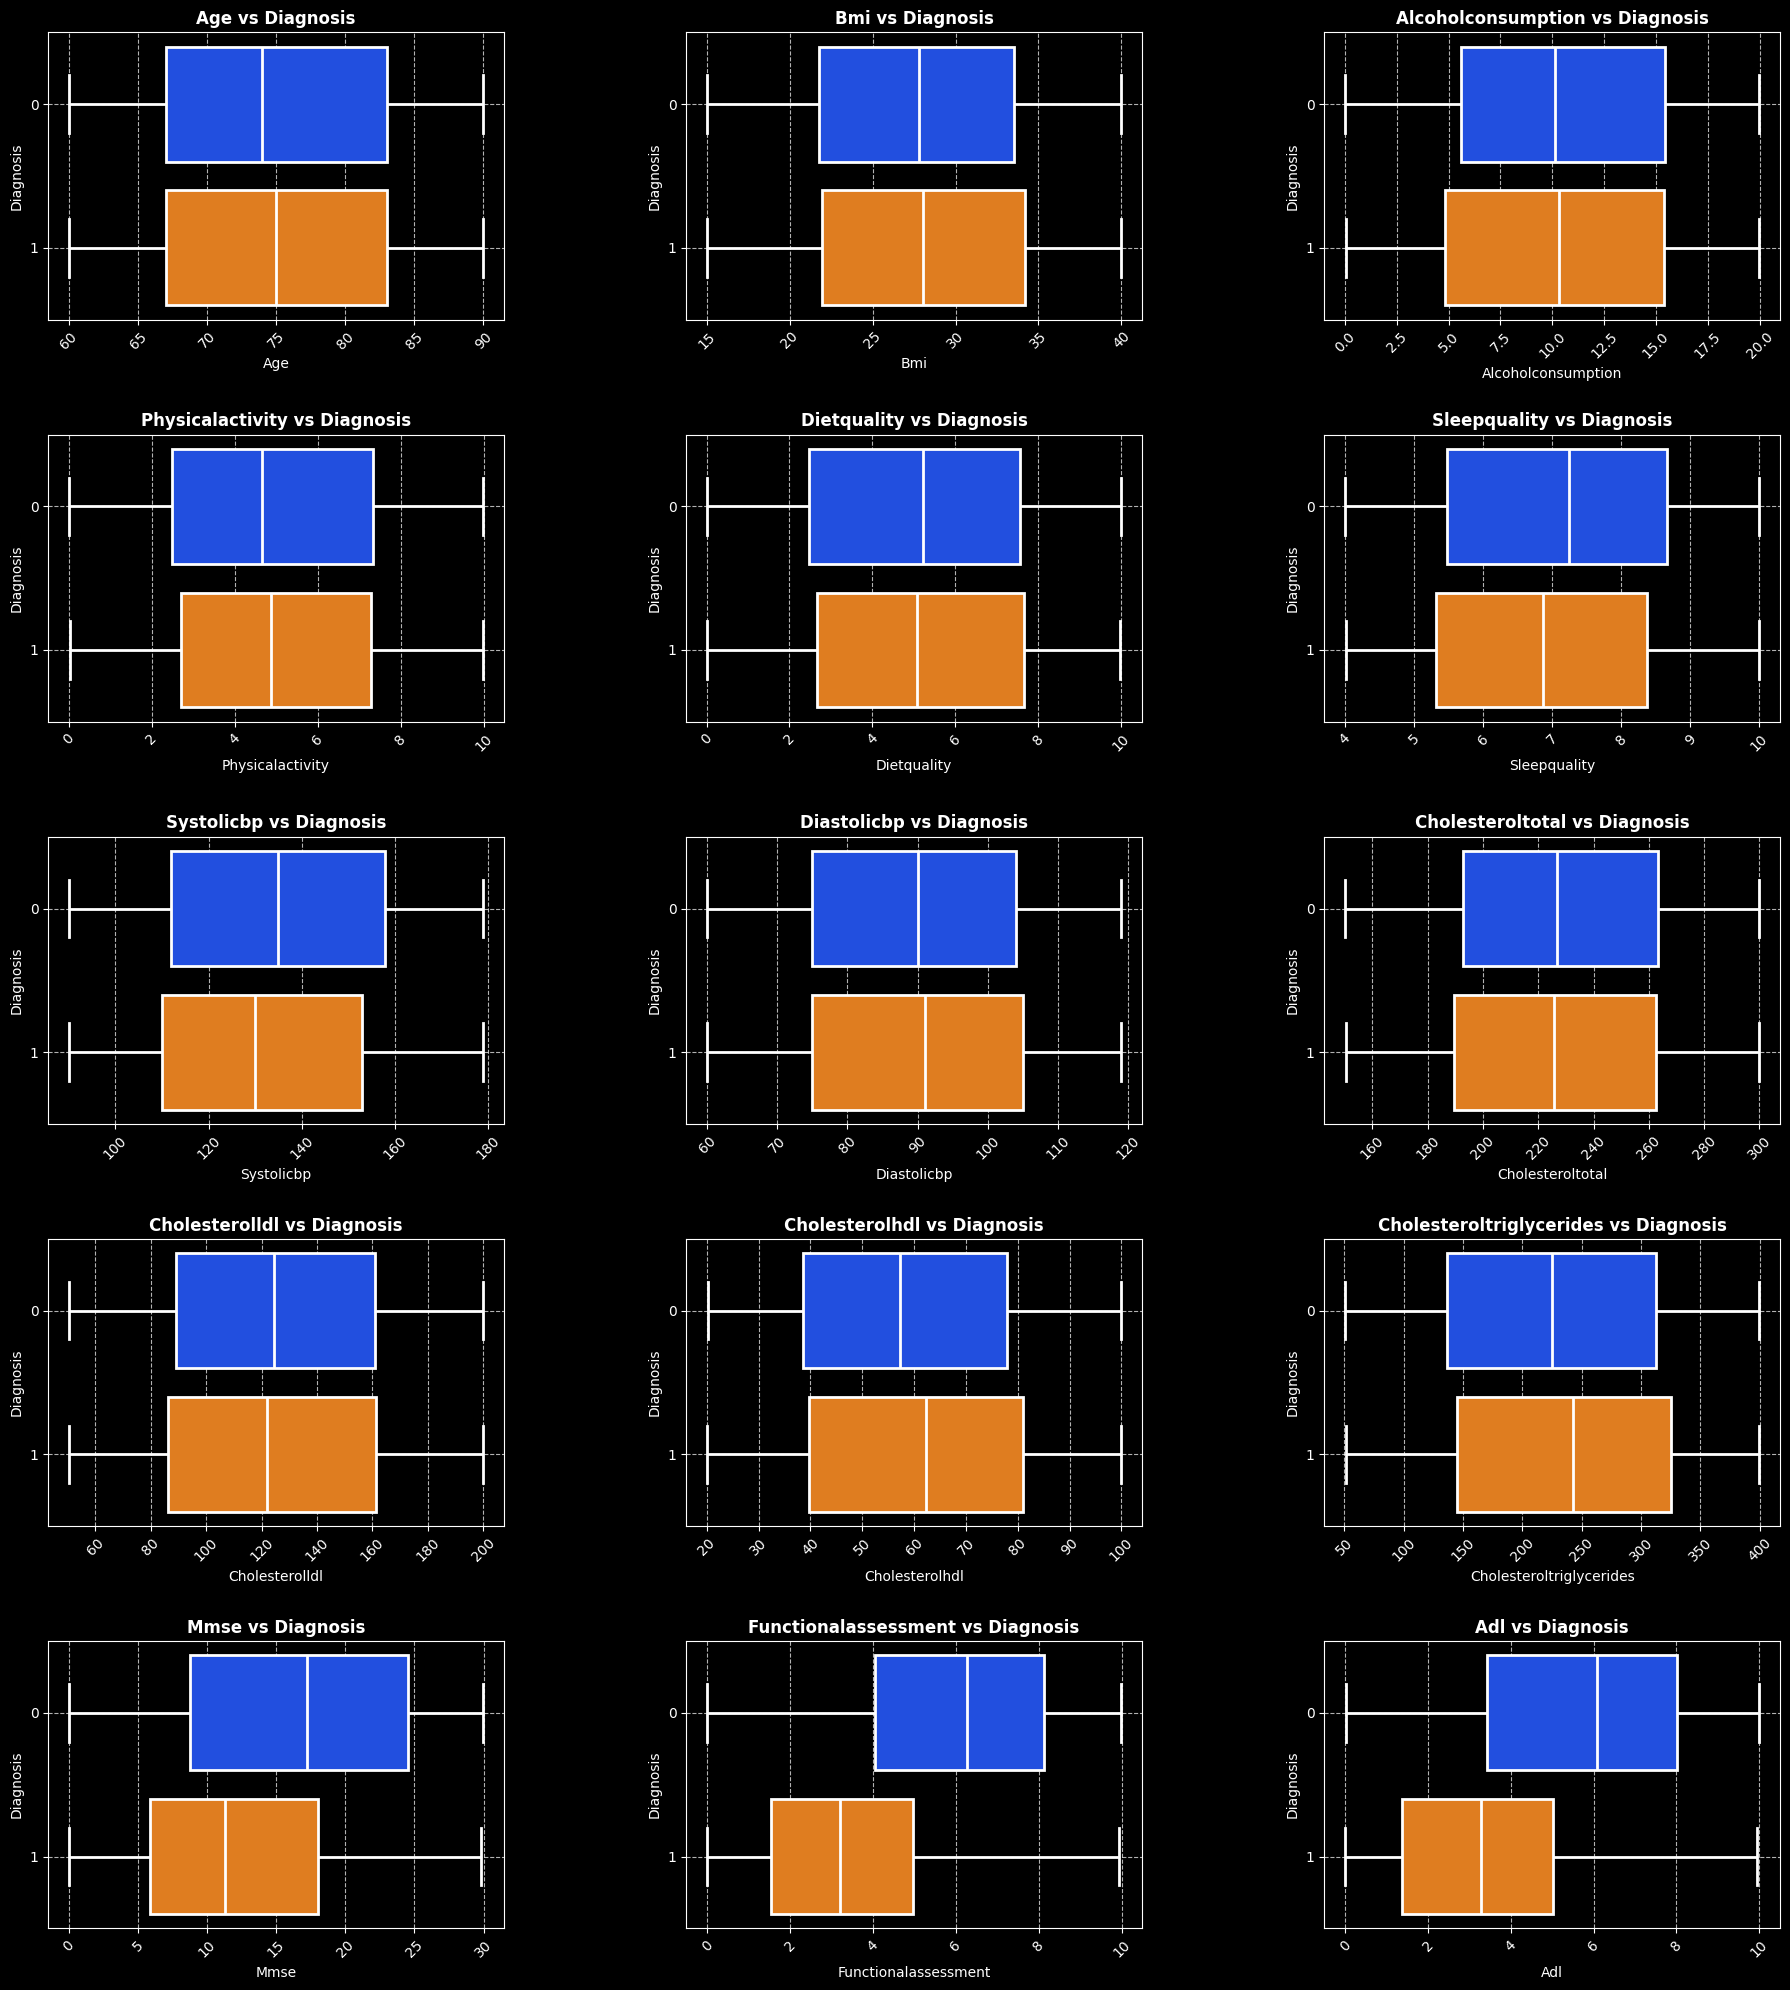

In [ ]:
plot = BoxPlotter(X_train, y_train)

for idx, col in enumerate(continuous_features):
    plot.plot_box(idx // 3, idx % 3, x=col)

plot.show_box_plots()

#### Balancing Training set

In [ ]:
def plot_data_distribution(X, y, title, ax):
    sns.countplot(x=y, palette='bright', ax=ax, edgecolor='white', linewidth=2)
    for p in ax.patches:
        count = p.get_height()
        total = len(y)
        percentage = 100 * count / total
        ax.annotate(
            f'{count} ({percentage:.1f}%)',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=9, color='black'
        )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Diagnosis', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

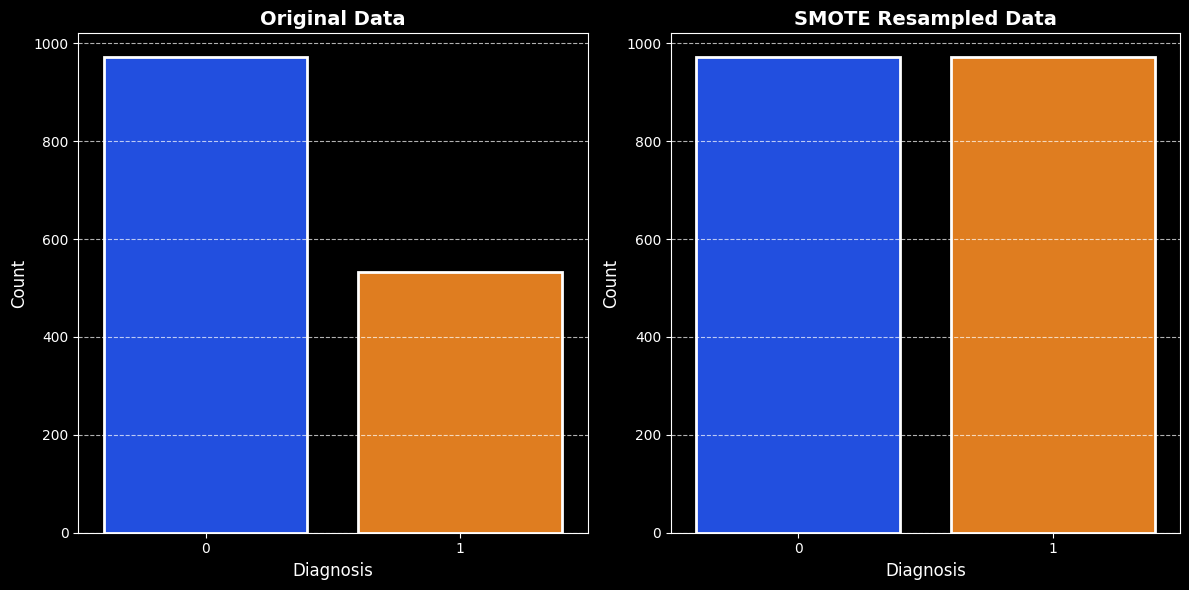

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_data_distribution(X_train, y_train, "Original Data", axes[0])

X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

plot_data_distribution(X_train, y_train, "SMOTE Resampled Data", axes[1])

plt.tight_layout()
plt.show()

#### Feature Selection

> Correlation Analysis

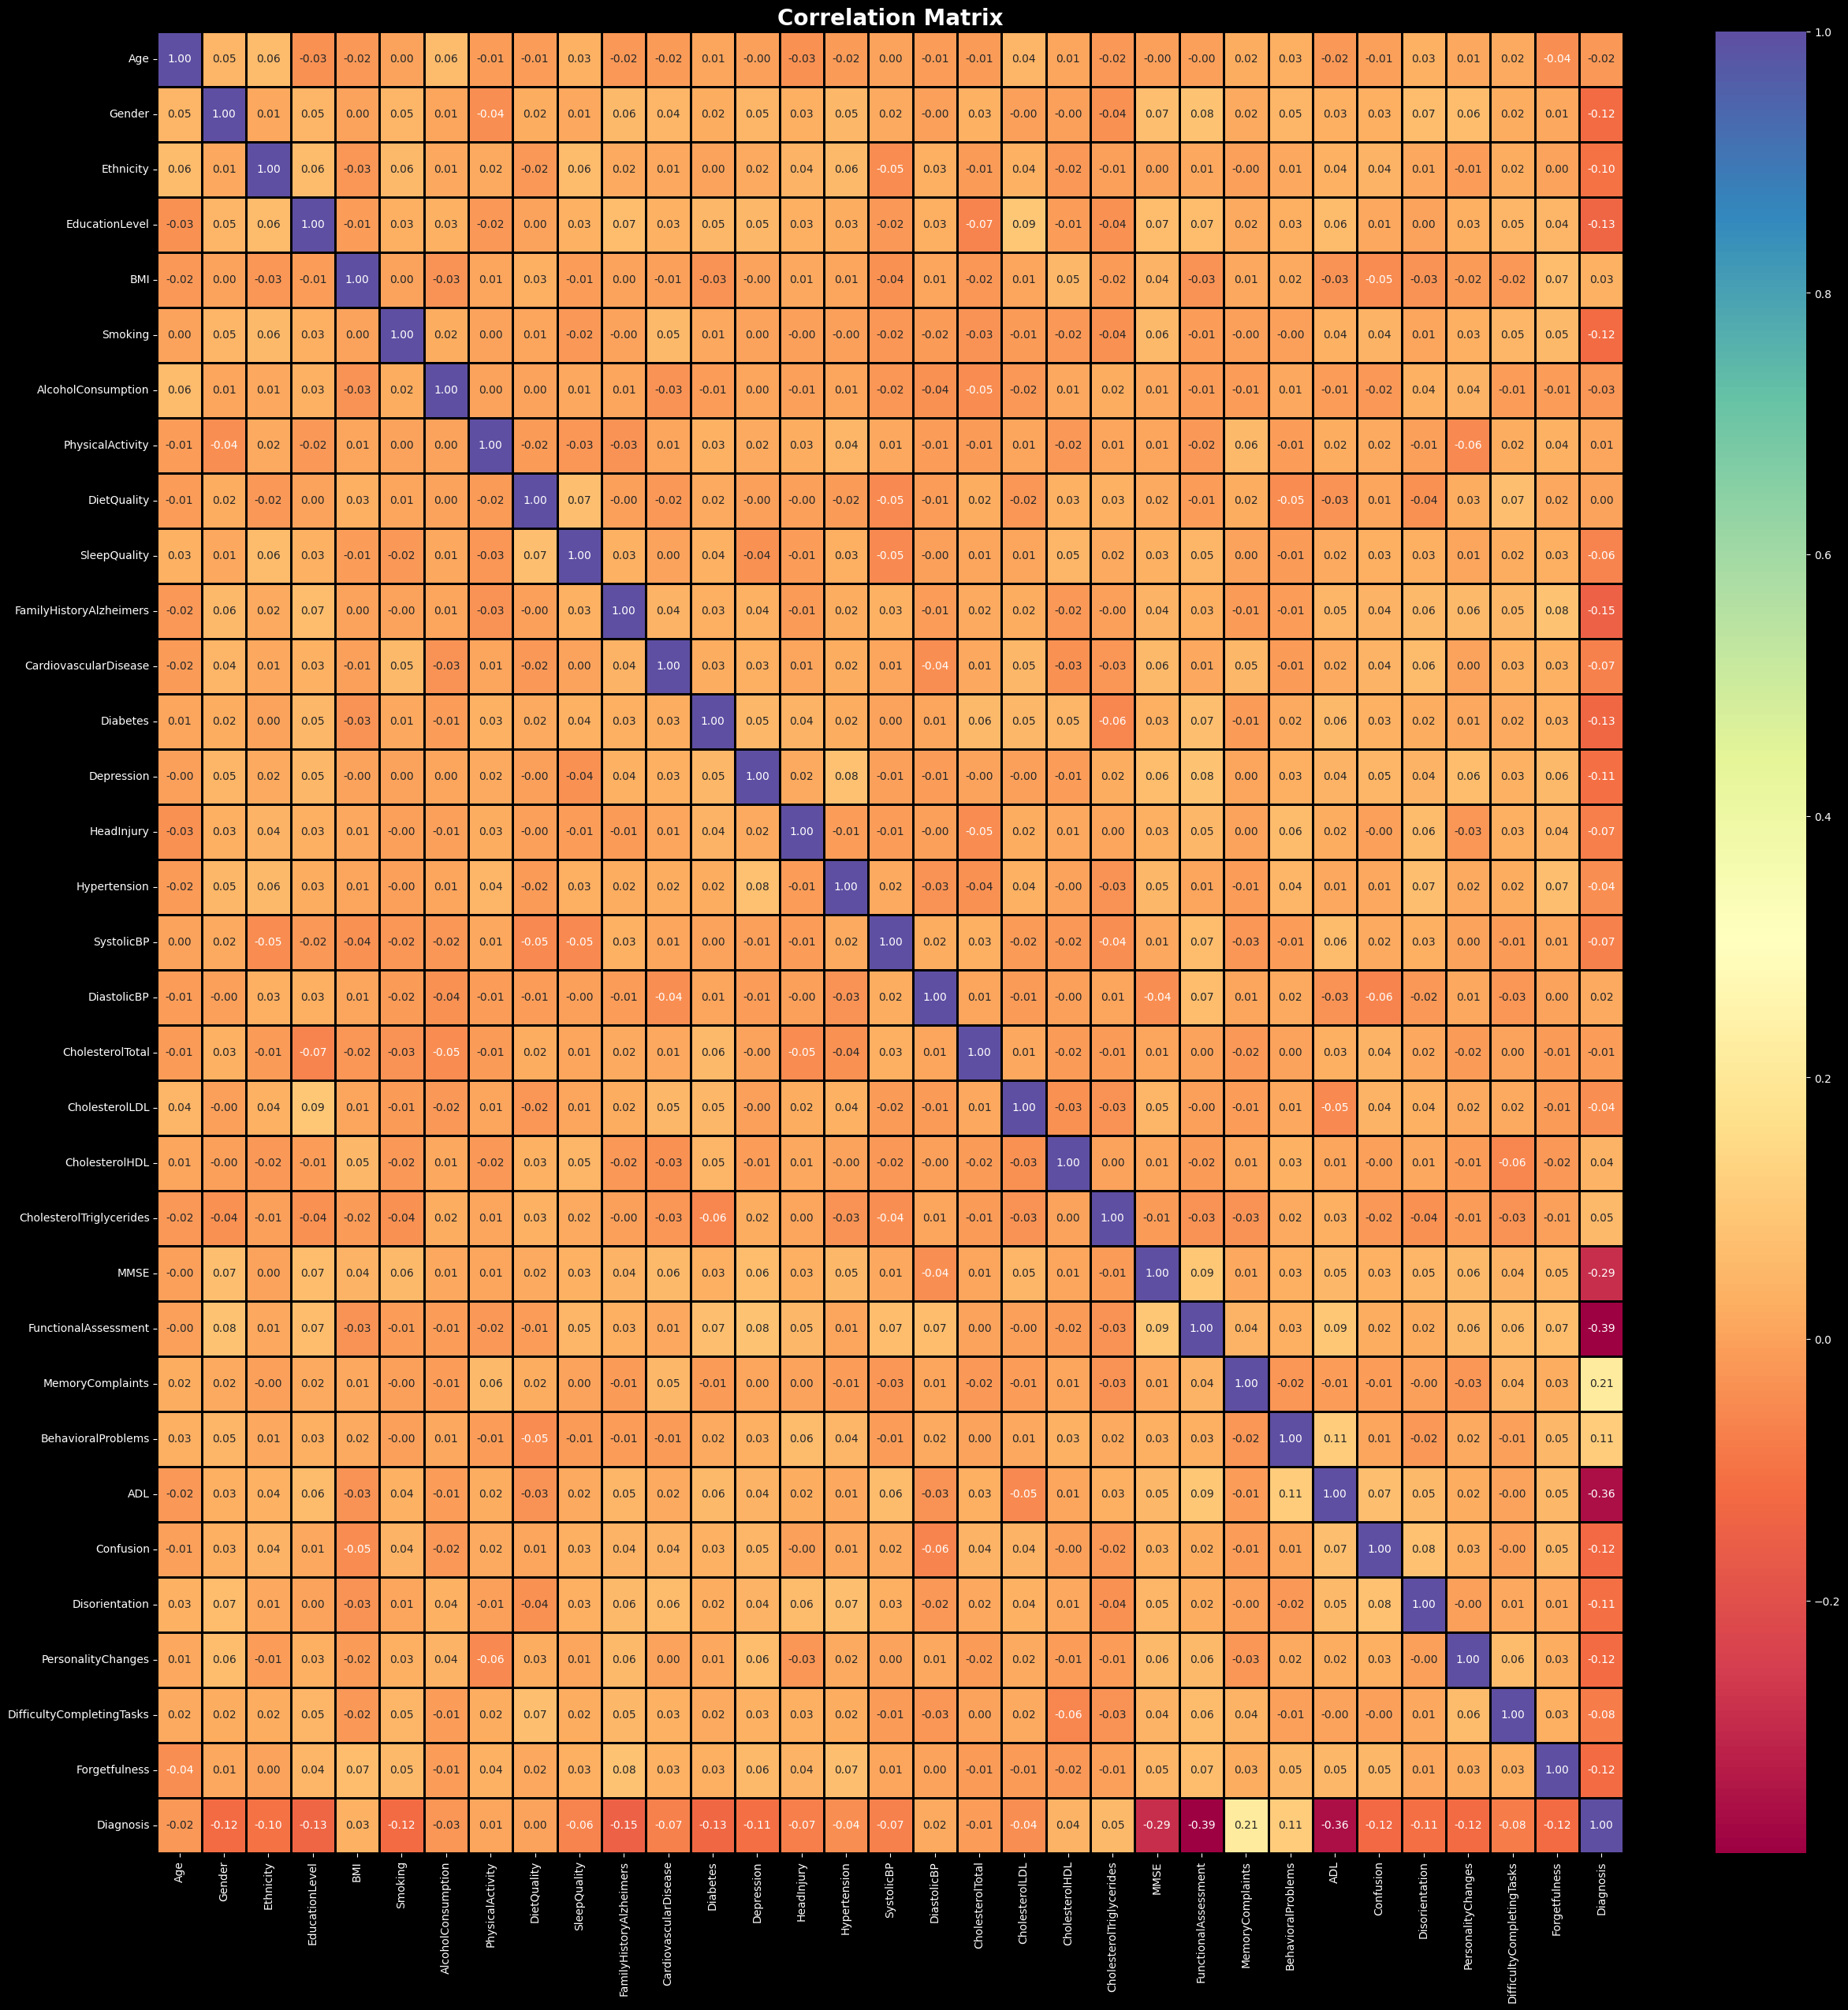

In [ ]:
train_copy = pd.concat(
    [X_train, y_train,], axis=1
)

corr_matrix = train_copy.corr()

plt.figure(figsize=(30, 30))
sns.heatmap(
    corr_matrix, cmap='Spectral', annot=True, fmt='.2f', linewidths=2, linecolor='black'
)
plt.title(
    'Correlation Matrix', fontsize=20, fontweight='bold'
)
plt.show()

> Mutual Information

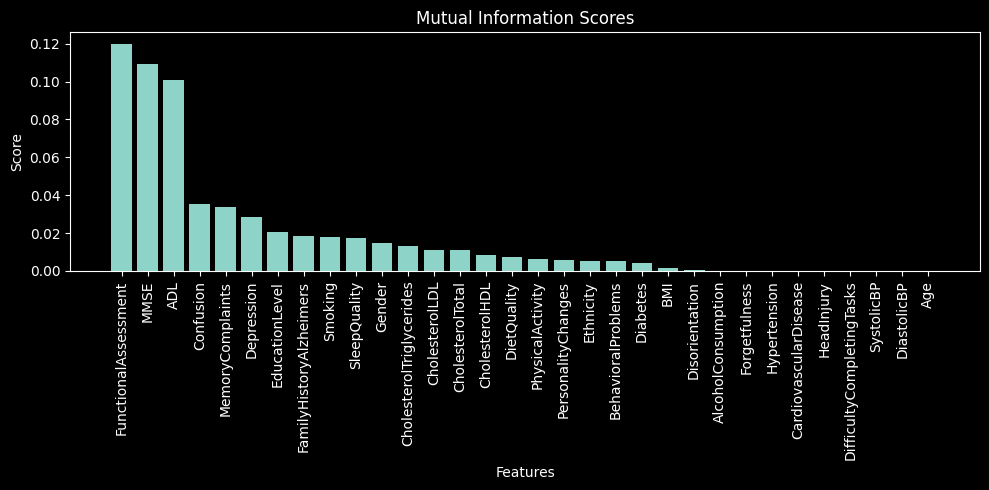

In [ ]:
feature_zero_count = {}

for X, Y in zip([X_train], [y_train]):
    feature_names = X.columns
    scores = mutual_info_classif(X, Y)
    indices = np.argsort(scores)[::-1]
    sorted_scores = scores[indices]
    sorted_feature_names = [feature_names[i] for i in indices]

    for feature, score in zip(feature_names, scores):
        if feature not in feature_zero_count:
            feature_zero_count[feature] = 0
        if score == 0:
            feature_zero_count[feature] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(sorted_scores)), sorted_scores)
    plt.xticks(
        range(len(sorted_scores)), sorted_feature_names, rotation='vertical'
    )
    plt.title('Mutual Information Scores')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

In [ ]:
features_to_drop = [
    feature for feature, zero_count in feature_zero_count.items()
    if zero_count >= 1
]

> Boruta algorithm

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

In [ ]:
feat_selector = BorutaPy(
    verbose=2, estimator=rfr, n_estimators='auto', max_iter=10
)

In [ ]:
feat_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	5
Tentative: 	1
Rejected: 	26
Iteration: 	9 / 10
Confirmed: 	5
Tentative: 	1
Rejected: 	26


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	27


BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=69,
                                         random_state=RandomState(MT19937) at 0x7CAA805EE340),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7CAA805EE340, verbose=2)

In [ ]:
cols_to_drop = []

print("~ Support and Ranking for each feature:")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ", X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])
        cols_to_drop.append(X_train.columns[i])

~ Support and Ranking for each feature:
Doesn't pass the test:  Age  - Ranking:  7
Doesn't pass the test:  Gender  - Ranking:  14
Doesn't pass the test:  Ethnicity  - Ranking:  16
Doesn't pass the test:  EducationLevel  - Ranking:  15
Doesn't pass the test:  BMI  - Ranking:  3
Doesn't pass the test:  Smoking  - Ranking:  23
Doesn't pass the test:  AlcoholConsumption  - Ranking:  11
Doesn't pass the test:  PhysicalActivity  - Ranking:  4
Doesn't pass the test:  DietQuality  - Ranking:  6
Doesn't pass the test:  SleepQuality  - Ranking:  5
Doesn't pass the test:  FamilyHistoryAlzheimers  - Ranking:  25
Doesn't pass the test:  CardiovascularDisease  - Ranking:  25
Doesn't pass the test:  Diabetes  - Ranking:  17
Doesn't pass the test:  Depression  - Ranking:  21
Doesn't pass the test:  HeadInjury  - Ranking:  28
Doesn't pass the test:  Hypertension  - Ranking:  24
Doesn't pass the test:  SystolicBP  - Ranking:  10
Doesn't pass the test:  DiastolicBP  - Ranking:  12
Doesn't pass the test: 

In [ ]:
print('~ Features to drop:\n')
print(f'Based on Mutual information scores: {features_to_drop}\n')
print(f'Based on Boruta algorithm: {cols_to_drop}')

~ Features to drop:

Based on Mutual information scores: ['Age', 'AlcoholConsumption', 'CardiovascularDisease', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'DifficultyCompletingTasks', 'Forgetfulness']

Based on Boruta algorithm: ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']


In [ ]:
X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

Feature Scaling

In [ ]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### Feature Extraction

Number of components for 95% variance: 5


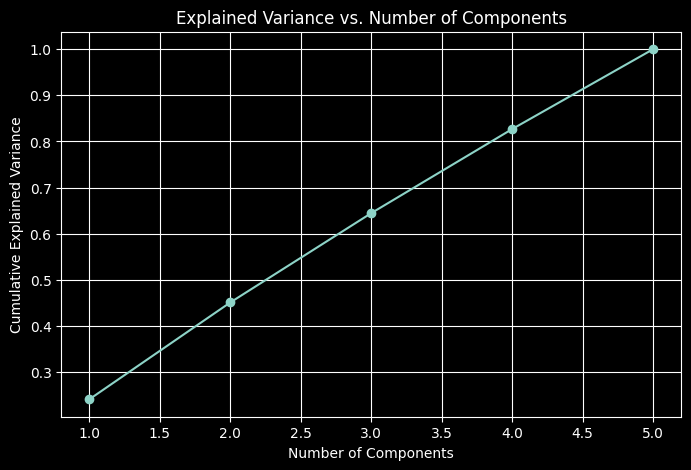

In [ ]:
pca = PCA()
pca.fit(scaled_X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print(f"Number of components for 95% variance: {n_components_95}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components=n_components_95)

train_reduced = pca.fit_transform(scaled_X_train)
test_reduced = pca.transform(scaled_X_test)

In [ ]:
params = {
    'C': [0.001,0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}

In [ ]:
grid_search = GridSearchCV(
    SVC(), params, cv=5, scoring='accuracy'
)
grid_search.fit(train_reduced, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [ ]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
res = pd.DataFrame({
    'Accuracy': [accuracy_score(y_train, grid_search.predict(train_reduced)), accuracy_score(y_test, grid_search.predict(test_reduced))],
    'Precision': [precision_score(y_train, grid_search.predict(train_reduced)), precision_score(y_test, grid_search.predict(test_reduced))],
    'Recall': [recall_score(y_train, grid_search.predict(train_reduced)), recall_score(y_test, grid_search.predict(test_reduced))],
    'F1-Score': [f1_score(y_train, grid_search.predict(train_reduced)), f1_score(y_test, grid_search.predict(test_reduced))]
}, index=['Training', 'Testing'])

In [ ]:
res

,Accuracy,Precision,Recall,F1-Score
Training,0.906893,0.942889,0.866255,0.902949
Testing,0.902326,0.839506,0.894737,0.866242
